In [1]:
import cirq
from cirq.contrib.svg import SVGCircuit
import sympy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
import tensorflow_quantum as tfq
from tqdm import tqdm
import pandas as pd

2022-08-05 10:03:25.921418: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-05 10:03:25.921743: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-05 10:03:34.388728: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-05 10:03:34.388913: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-05 10:03:34.389425: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vt-toscanoni): /proc/driver/nvidia/version does not exist
2022-08-05 10:03:34.390598: I tensorflow/core/platform/cpu_featu

In [2]:
def generate_data_diff(qubits, xs):
    """
    Pass x-points through differentiated feature map
    """
    f_map_diff = []
    shift = [0]*len(qubits)
    for x in xs:
        dfx = []
        for s in range(len(qubits)):
            ps_couple = []
            for sign in [1,-1]:
                ps_signs = []
                shift[s] = sign*np.pi/2
                for i,q in enumerate(qubits):
                    ps_signs.append(cirq.ry(2*np.arccos(x) + shift[i])(q))
                shift[s] = 0
                ps_couple.append(cirq.Circuit(ps_signs))

            dfx.append(tfq.convert_to_tensor(ps_couple))
        f_map_diff.append(dfx)

    return f_map_diff

def generate_data(qubits, xs):
    """
    Pass x-points through standard feature map
    """
    f_map = []
    for x in xs:
        fx = []
        for i,q in enumerate(qubits):
            fx.append(cirq.ry(2*np.arccos(x))(q))
            
        f_map.append(cirq.Circuit(fx))

    return tfq.convert_to_tensor(f_map)

In [3]:
def single_qubit_rotations(q, symbols):

    return [cirq.rz(symbols[0])(q),
            cirq.rx(symbols[1])(q),
            cirq.rz(symbols[2])(q)]

def cnots(qubits):
    
    cnots = [cirq.CNOT(qc, qt) for qc, qt in zip(qubits, qubits[1:])]
    cnots += ([cirq.CNOT(qubits[-1], qubits[0])] if len(qubits) != 2 else [])
    
    return cnots

In [4]:
def parametrized_circuit(qubits, layers=5):
    """
    Create parametrized circuit with single qubit rotations and CNOT layer
    """
    n_qubits = len(qubits)
    circuit = cirq.Circuit()

    # Sympy symbols for variational angles
    thetas = sympy.symbols(f'theta_(0:{layers*n_qubits*3})')
    thetas = np.asarray(thetas).reshape((layers, n_qubits, 3))

    for l in range(layers):
        # add Variational layer and cnot gates
        circuit += [single_qubit_rotations(q, thetas[l, i]) for i,q in enumerate(qubits)]
        circuit += cnots(qubits)

    return circuit

In [5]:
def get_obs(qubits):
    """
    Create observation (total magnetization)
    """
    return sum([cirq.Z(q) for q in qubits])

In [6]:
def q_diff_model(qubits):
    """
    Create VQC model with tensorflow quantum which includes:
     - input layer (x data filtered through feature map)
     - differentiable parametrized circuit (Adjoint differentiation)
     - observations
    """
    obs = get_obs(qubits)
    diff = tfq.differentiators.Adjoint()
    input_layer = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
    model = tfq.layers.PQC(parametrized_circuit(qubits),
                            obs,
                            differentiator=diff,
                            initializer=tf.keras.initializers.RandomUniform(-np.pi,np.pi)
                            )(input_layer)
    q_model = tf.keras.Model(inputs=[input_layer], outputs=[model])
    return q_model

In [7]:
def model_output_diff(model,qubits,xt,dmt):
    """
    Output of the VQC model which will be compared to du(x)/dx
    following equations 8-10 of paper https://arxiv.org/pdf/2011.10395.pdf
    """
    dy = []
    for i in range(len(xt)):
        z_plus = 0
        z_minus= 0
        for k in range(len(qubits)):
            z_plus += model(dmt[i][k])[0]
            z_minus += model(dmt[i][k])[1]
        d_phi = -2/np.sqrt(1-xt[i]**2)
        diff_value = 0.5*d_phi*(z_plus-z_minus)
        
        dy.append(diff_value[0])
    return tf.convert_to_tensor(dy)

def model_output(model,map):
    """
    Output of the VQC model which will be compared to u(x)
    """
    y = []
    model_output = model(map)
    for i in range(len(map)):
        value = model_output[i]
        y.append(value[0])
    return tf.convert_to_tensor(y)

In [8]:
def u(x,k,l):
    return np.exp(-k*l*x) * np.cos(l*x)

In [73]:
class Trainer:
    """
    Custom trainer class for the model.
    Takes into account:
     - training data (#20)
     - floating boundary handling
     - regularization data (#15) (reverse sigmoid optimization schedule)
     - quality check

    Run have been executed with 
     - fixed training points and regularization points 

    """
    def __init__(self, qubits, max_steps, tol, 
                n_layers=5, t_points=20, r_points=6, debug=False):
        
        self.qubits = qubits
        self.n_layers = n_layers
        self.model = q_diff_model(qubits)
        self.opt = Adam(learning_rate=0.03)
        
        self.max_steps = max_steps
        self.step = 0
        self.tol = tol

        self.l = 8
        self.k = 0.1

        self.xt = np.linspace(0,0.9,t_points)
        self.xr = np.linspace(0,0.9,r_points)
        self.xb = np.array([0])
        self.x_quality = np.linspace(0,0.9,50)

        self.dmap_t = generate_data_diff(qubits,self.xt)
        self.map_t = generate_data(qubits,self.xt)
        self.map_r = generate_data(qubits,self.xr)
        self.map_b = generate_data(qubits,self.xb)
        self.map_quality = generate_data(qubits,self.x_quality)

        self.yr_true = u(self.xr,self.k,self.l)
        self.yb_true = u(self.xb,self.k,self.l)
        self.yq_true = u(self.x_quality,self.k,self.l)
        #self.dy_true = du(self.xt)
        
    def update_model(self):
        
        reg_coeff = 1 - np.tanh((self.step - self.max_steps*0.3)/(0.25*self.max_steps))

        with tf.GradientTape() as g:
            
            # floating boundary handling     
            yb = model_output(self.model,self.map_b)
            fb = self.yb_true - yb
            
            # differential value
            dyt = model_output_diff(self.model,self.qubits,self.xt,self.dmap_t)
            yt = model_output(self.model,self.map_t) + fb
            dy_true = - self.l*yt*(self.k + tf.math.tan((self.l*self.xt).astype('float32')))
            
            # regularization
            yr = model_output(self.model,self.map_r)
            
            # losses
            diff_loss = MSE(dyt,dy_true)
            reg_loss = tf.cast(reg_coeff*MSE(yr, self.yr_true), tf.float32)
            loss = diff_loss + reg_loss
            
        gradient = g.gradient(loss, self.model.trainable_weights)
        self.opt.apply_gradients(zip(gradient, self.model.trainable_weights))

        y_quality = model_output(self.model,self.map_quality)
        quality_loss = MSE(y_quality, self.yq_true)

        return loss, diff_loss, quality_loss, reg_loss, fb

    def learn(self):
        stat = {}
        weights = {}
        df = pd.DataFrame(columns=['Quality loss',
                                   'Total loss',
                                   'Differential loss',
                                   'Boundary loss',
                                   'Regularization loss'])

        with tqdm(range(self.max_steps)) as steps:
            for s in steps:
                loss, diff_loss, quality_loss, reg_loss, fb = self.update_model()
                stat['diff loss'] = round(diff_loss.numpy(),5)
                stat['reg loss'] = round(reg_loss.numpy(),5)
                stat['bound loss'] = round(fb.numpy()[0],5)
                stat['full loss'] = round(loss.numpy(),5)
                stat['quality loss'] = round(quality_loss.numpy(),5)

                df.loc[s] = [quality_loss.numpy(),
                            loss.numpy(),
                            diff_loss.numpy(),
                            fb.numpy()[0],
                            reg_loss.numpy()
                            ]

                steps.set_postfix(stat)
                self.step += 1
                
                if self.step % 20 == 0 or self.step == 1:
                    weights[self.step] = tf.convert_to_tensor(self.model.trainable_weights)
                if self.step == self.max_steps:
                    weights[self.step] = tf.convert_to_tensor(self.model.trainable_weights)

                if loss < self.tol:
                    print('Loss already lower than tolerance!')
                    break
        return df, weights


# Tests

In [74]:
n_qubits = 6
n_layers = 5
max_steps = 250
qubits = [cirq.LineQubit(i) for i in range(n_qubits)]

trainer = Trainer(qubits, n_layers=n_layers, max_steps=max_steps, tol=1.e-5, debug=False)

In [75]:
df, trained_weights = trainer.learn()

100%|██████████| 250/250 [13:05<00:00,  3.14s/it, diff loss=0.558, reg loss=4e-5, bound loss=0.00603, full loss=0.558, quality loss=0.00782]   


In [76]:
pd.options.plotting.backend = "plotly"
df.plot(x=df.index, y=['Quality loss', 
                               'Total loss',
                               #'Boundary loss',
                               'Differential loss'], log_y=True)

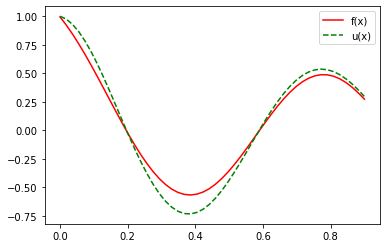

In [77]:
q_final = q_diff_model(qubits)
q_final.set_weights(trained_weights[max_steps])

x = np.linspace(0,0.9,50)
fm = generate_data(qubits,x)
f = q_final(fm)
f = [y[0] for y in f.numpy()]

k = 1.e-1
l = 8

y = u(x,k,l)

plt.plot(x, f, 'r', label='f(x)')
plt.plot(x, y, 'g--', label='u(x)')

plt.legend()
plt.show()

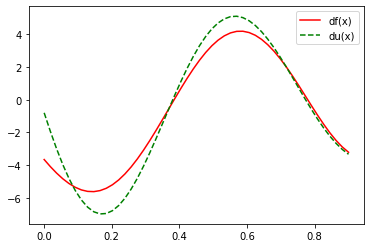

In [78]:
q_final = q_diff_model(qubits)
q_final.set_weights(trained_weights[max_steps])

x = np.linspace(0,0.9,50)
dfm = generate_data_diff(qubits,x)
yr = model_output_diff(q_final,qubits,x,dfm)

y_fit = l*np.exp(-l*k*x)*(-k*np.cos(l*x) - np.sin(l*x))

plt.plot(x, yr, 'r', label='df(x)')
plt.plot(x, y_fit, 'g--', label='du(x)')

plt.legend()
plt.show()